In [10]:
from data_process import data_process
from module import KGAT
from lossfunction import bpr_loss
from tools import negative_sampling
import torch
from tqdm import trange
from torch_geometric.data import HeteroData
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
data_process = data_process('../data/ml-latest-small/')
edge_index, id_mappings, num_users, num_items = data_process.process_data(rating_path="ratings.csv",
    movie_path="movies.csv")
print(edge_index)
print(id_mappings)
print(num_users)
print(num_items)


tensor([[        0.,         2.,         5.,  ...,      9462.,      9463.,
              9503.],
        [        0.,         0.,         0.,  ...,       609.,       609.,
               609.],
        [        4.,         4.,         4.,  ...,         5.,         5.,
                 3.]])
{'user': {'id_to_index': {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4, np.int64(6): 5, np.int64(7): 6, np.int64(8): 7, np.int64(9): 8, np.int64(10): 9, np.int64(11): 10, np.int64(12): 11, np.int64(13): 12, np.int64(14): 13, np.int64(15): 14, np.int64(16): 15, np.int64(17): 16, np.int64(18): 17, np.int64(19): 18, np.int64(20): 19, np.int64(21): 20, np.int64(22): 21, np.int64(23): 22, np.int64(24): 23, np.int64(25): 24, np.int64(26): 25, np.int64(27): 26, np.int64(28): 27, np.int64(29): 28, np.int64(30): 29, np.int64(31): 30, np.int64(32): 31, np.int64(33): 32, np.int64(34): 33, np.int64(35): 34, np.int64(36): 35, np.int64(37): 36, np.int64(38): 37, np.int64(39): 38,

In [12]:

model = KGAT(batch_size=1024, embedding_dim=100,device=device).to(device)
users_embedding = model.embedding(num_users)
items_embedding = model.embedding(num_items)
print("users_embedding.shape:",users_embedding.shape)
print("items_embedding.shape:",items_embedding.shape)


users_embedding.shape: torch.Size([610, 100])
items_embedding.shape: torch.Size([9742, 100])


In [13]:
data = HeteroData()
data['user'].x = users_embedding
data['item'].x = items_embedding
data["edge_index"] = edge_index[0:2].int()
data["edge_wight"] = edge_index[2].long()
print(data["edge_index"])
print(data["edge_wight"])




tensor([[   0,    2,    5,  ..., 9462, 9463, 9503],
        [   0,    0,    0,  ...,  609,  609,  609]], dtype=torch.int32)
tensor([4, 4, 4,  ..., 5, 5, 3])


In [14]:
Iteration = 5126
learning_rate = 2e-3
weight_decay = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_list = []

In [ ]:
for iter in trange(Iteration):
    user_embedding_final,item_embedding_final = model.forward(data)
    user_embedding_0 = data['user'].x
    item_embedding_0 = data['item'].x
    
    neg_item_index = negative_sampling(data["edge_index"],num_negatives=10)
    neg_item_embedding_0 = item_embedding_0[neg_item_index].to(device)
    neg_item_embedding_final = item_embedding_final[neg_item_index].to(device)

    user_embedding_0 = user_embedding_0.to(device)
    item_embedding_0 = item_embedding_0.to(device)
    edge_index = data["edge_index"][0:2].to(device)

    loss, reg_loss, bpr_loss_val = bpr_loss(user_embedding_final,user_embedding_0,item_embedding_final,item_embedding_0,item_embedding_0,item_embedding_0,edge_index,lambda_val=1e-5)
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    loss_list.append(loss.item())
    if iter % 256 == 0:
        print("loss:",loss.item())
print(data['user'].x.shape,data['item'].x.shape)

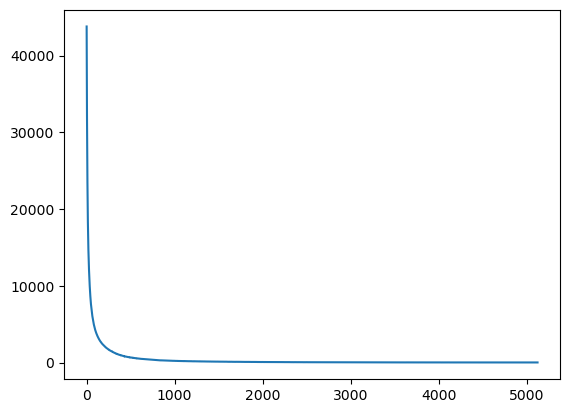

In [16]:
plt.plot(loss_list)
plt.show()